# Loading

In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
import helper as hp

import os
from abc import ABC, abstractmethod
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss
from models import * 

current_path = os.getcwd()
random_state = hp.RANDOM_STATE

STOCKS = ["AMC", "TSLA", "AAPL", "MSFT", "AMZN", "GOOG", 'AMD', "NVDA", 'QQQ', "SPY", "DIA", "^IRX"]
START_DATE = hp.START_DATE
END_DATE = hp.END_DATE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# data fetching 
stock_data = {}
for stock in STOCKS:
    data_path = os.path.join(current_path, "data", f"{stock}_{START_DATE}_{END_DATE}.csv")
    data = pd.read_csv(data_path)
    stock_data[stock] = data
stock_data = hp.preprocess_stock_data(stock_data, STOCKS)

Data fetched for AMC
Data fetched for TSLA
Data fetched for AAPL
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for AMD
Data fetched for NVDA
Data fetched for QQQ
Data fetched for SPY
Data fetched for DIA
Data fetched for ^IRX


## Paramenters

In [8]:
fromDate = "2019-01-01"
toDate = '2023-11-01'
# fromDate = "2015-01-01"
# toDate = '2017-01-01'
STOCK = 'AMC'
lag = 5
window_size = 40
starting_funds = 50000

# Non-Stationary

In [9]:
stationary = False
X, y, df_stock = hp.prepare_data(stock_data, STOCK, fromDate, toDate, lag, stationary=stationary)
loss_fn = 'reg:squarederror' #'reg:squaredlogerror'

# params = {'n_estimators': 309, 
#           'max_depth': 5, 
#           'min_child_weight': 3, 
#           'gamma': 0.15186097003049082, 
#           'learning_rate': 0.05374239491599335, 
#           'subsample': 0.7113104114026579, 
#           'colsample_bytree': 0.9251376238321264, 
#           'reg_alpha': 0.0021887652757847653, 
#           'reg_lambda': 0.014582652001637117
#         }   # MAE 1.82

params = {'n_estimators': 323, 
          'max_depth': 7, 
          'min_child_weight': 2, 
          'gamma': 0.10020565066030232, 
          'learning_rate': 0.08013623310286376, 
          'subsample': 0.9541002999199182, 
          'colsample_bytree': 0.659370350154071, 
          'reg_alpha': 0.029553047788818548, 
          'reg_lambda': 0.00021589152386430175
          } # MAE 1.79

## XGBoost

In [10]:
xgboost_model = XGBoost(loss_fn, params)
xgboost_stock_predictor = StockPredictor(xgboost_model, window_size=window_size, stationary=stationary)
xgboost_stock_predictor.fit_predict(X, y, df_stock)
xgboost_stock_predictor.print_metrics()

Processing: 100%|██████████| 1167/1167 [01:42<00:00, 11.40it/s]

Mean Squared Error (MSE): 491.1990
Mean Absolute Error (MAE): 8.5935


8.593543187477628

29.282070345011658


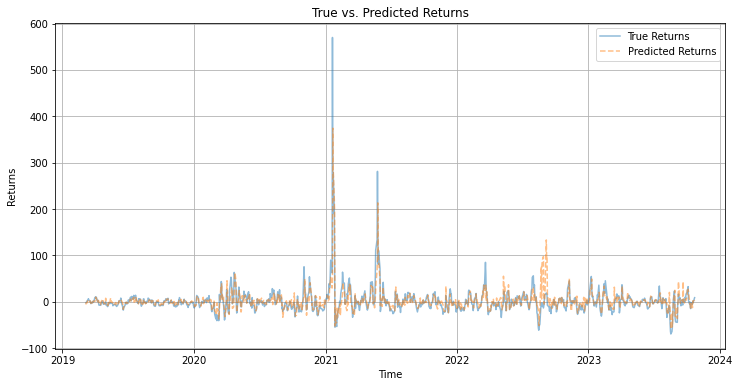

In [11]:
true_returns = xgboost_stock_predictor.true_returns
predicted_returns = xgboost_stock_predictor.predicted_returns
print(np.std(true_returns))
plt.figure(figsize=(12, 6))
plt.plot(xgboost_stock_predictor.dates[xgboost_stock_predictor.window_size:],true_returns, label='True Returns', linestyle='-', alpha=0.5)
plt.plot(xgboost_stock_predictor.dates[xgboost_stock_predictor.window_size:], predicted_returns, label='Predicted Returns', linestyle='--', alpha=0.5)
plt.title('True vs. Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

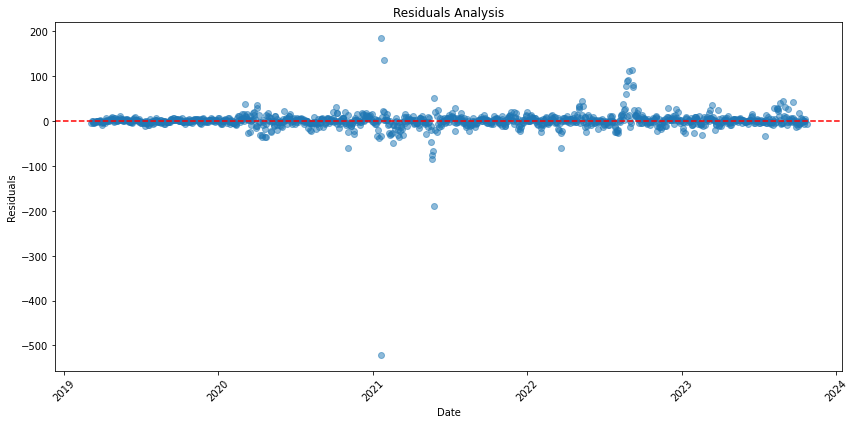

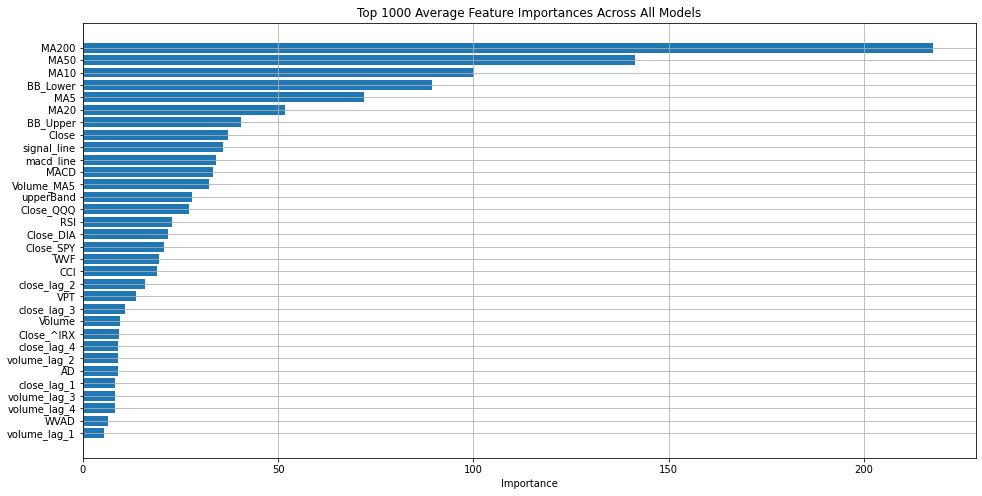

In [14]:
xgboost_stock_predictor.plot_residuals()
xgboost_stock_predictor.show_feature_importance(n=1000)

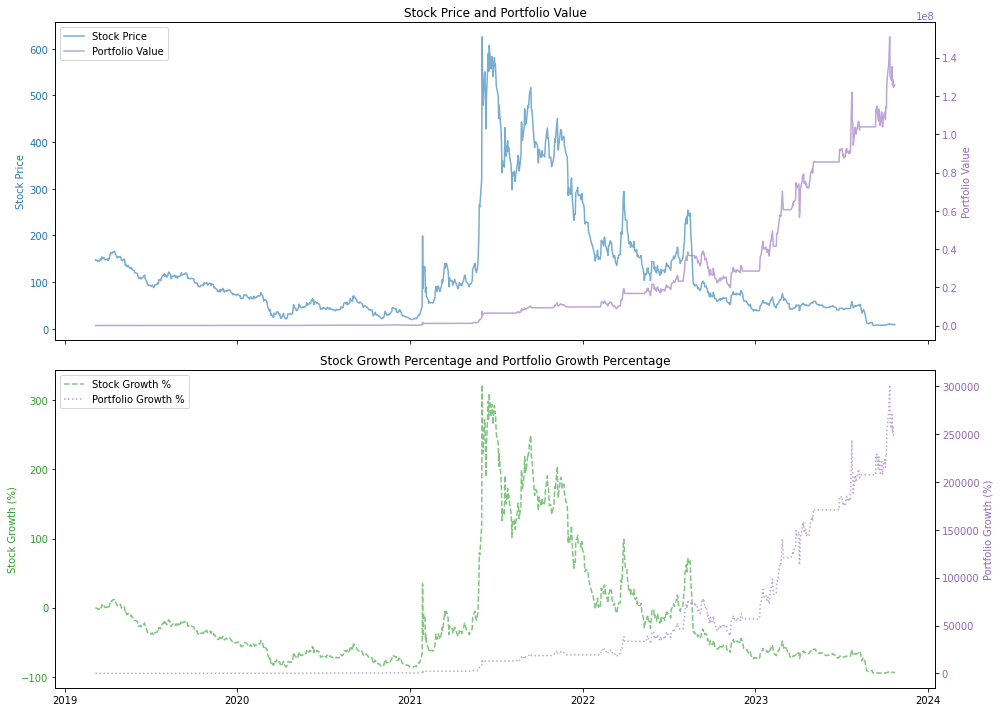

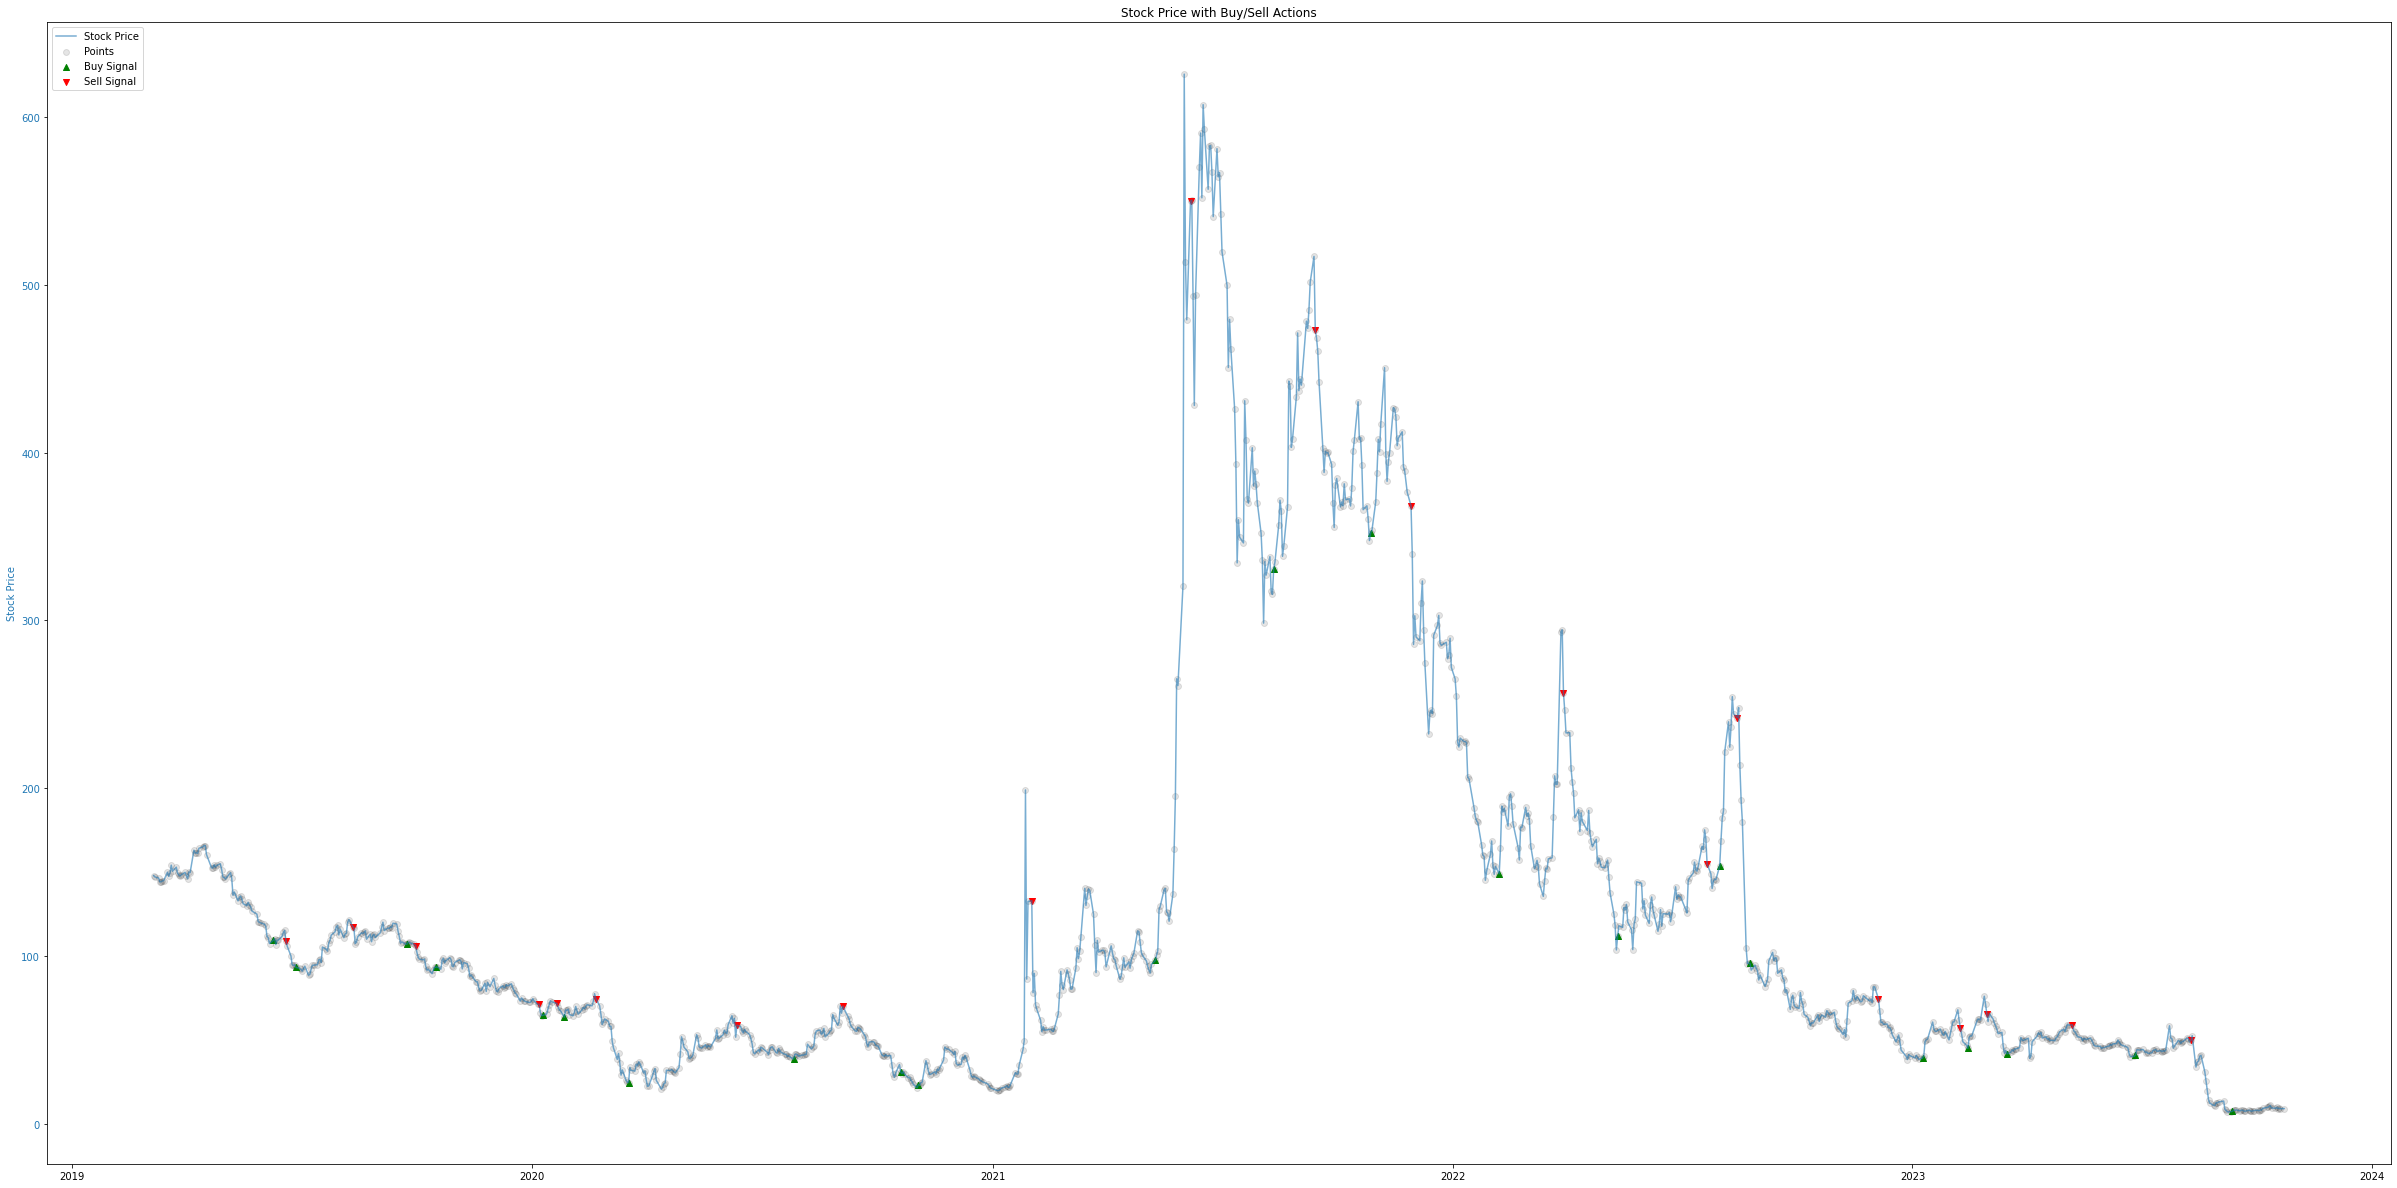

In [28]:
buys, sells, portfolio_value, portfolio_growth_percentage, dates, stock_prices = hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=xgboost_stock_predictor.true_returns,
    predicted_returns=xgboost_stock_predictor.predicted_returns,
    starting_funds=50000
)
fig, fig2 = hp.plot_signal_returns(buys, sells, portfolio_value, portfolio_growth_percentage, dates, stock_prices)

### Window Size Selection

In [11]:
# window_sizes = [5, 10, 20, 40, 80, 160, 320, 640, 1280, 2560]
# mape_values = []
# xgboost_model = XGBoost(loss_fn, params)
# for window in window_sizes:
#     xgboost_stock_predictor = StockPredictor(xgboost_model, window_size=window, stationary=stationary)
#     xgboost_stock_predictor.fit_predict(X, y, df_stock)
#     mape_values.append(xgboost_stock_predictor.print_metrics())

Processing: 100%|██████████| 3248/3248 [03:47<00:00, 14.28it/s]
Mean Squared Error (MSE): 7.5503
Mean Absolute Error (MAE): 2.0919
Processing: 100%|██████████| 3243/3243 [03:59<00:00, 13.55it/s]
Mean Squared Error (MSE): 6.5008
Mean Absolute Error (MAE): 1.9264
Processing: 100%|██████████| 3233/3233 [04:00<00:00, 13.43it/s]
Mean Squared Error (MSE): 6.7170
Mean Absolute Error (MAE): 1.9485
Processing: 100%|██████████| 3213/3213 [04:23<00:00, 12.18it/s]
Mean Squared Error (MSE): 6.2436
Mean Absolute Error (MAE): 1.8836
Processing: 100%|██████████| 3173/3173 [05:09<00:00, 10.25it/s]
Mean Squared Error (MSE): 6.2501
Mean Absolute Error (MAE): 1.8715
Processing: 100%|██████████| 3093/3093 [06:46<00:00,  7.60it/s]
Mean Squared Error (MSE): 7.9529
Mean Absolute Error (MAE): 2.0051
Processing: 100%|██████████| 2933/2933 [09:21<00:00,  5.22it/s]
Mean Squared Error (MSE): 6.9490
Mean Absolute Error (MAE): 1.9744
Processing: 100%|██████████| 2613/2613 [11:05<00:00,  3.93it/s]
Mean Squared Error (MSE): 7.0130
Mean Absolute Error (MAE): 1.9748

### Hyperparameter Tunning

In [12]:
# import optuna
# from optuna.visualization import plot_optimization_history, plot_param_importances

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'max_depth': trial.suggest_int('max_depth', 3, 7),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
#         'gamma': trial.suggest_float('gamma', 0.1, 1.0),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True)
#     }
#     loss_fn = 'reg:squarederror'
#     xgboost_model = XGBoost(loss_fn, params)
#     xgboost_stock_predictor = StockPredictor(xgboost_model, window_size=window_size, stationary=stationary)
#     xgboost_stock_predictor.fit_predict(X, y, df_stock)
#     return xgboost_stock_predictor.print_metrics()

# study = optuna.create_study(direction='minimize', pruner=optuna.pruners.SuccessiveHalvingPruner())
# study.optimize(objective, n_trials=66)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)


[I 2023-11-27 02:00:49,382] A new study created in memory with name: no-name-ce4a131f-891a-4306-9689-6ded98dbb19b
Processing: 100%|██████████| 3213/3213 [04:36<00:00, 11.62it/s]
[I 2023-11-27 02:05:25,865] Trial 0 finished with value: 2.3292378725309923 and parameters: {'n_estimators': 466, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.7673053725431062, 'learning_rate': 0.09636315959684784, 'subsample': 0.7245200566353671, 'colsample_bytree': 0.7511449346603408, 'reg_alpha': 0.1466622901519806, 'reg_lambda': 0.6906484896659022}. Best is trial 0 with value: 2.3292378725309923.
Mean Squared Error (MSE): 9.0497
Mean Absolute Error (MAE): 2.3292
Processing: 100%|██████████| 3213/3213 [02:55<00:00, 18.29it/s]
[I 2023-11-27 02:08:21,564] Trial 1 finished with value: 2.003326504559642 and parameters: {'n_estimators': 235, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.2480081947272763, 'learning_rate': 0.06351621582631019, 'subsample': 0.8807977909958766, 'colsample_bytree': 0.7856269046194266, 'reg_alpha': 0.002091484044331709, 'reg_lambda': 2.121052525242706e-05}. Best is trial 1 with value: 2.003326504559642.
Mean Squared Error (MSE): 6.9971
Mean Absolute Error (MAE): 2.0033
Processing: 100%|██████████| 3213/3213 [02:51<00:00, 18.72it/s]
[I 2023-11-27 02:11:13,241] Trial 2 finished with value: 2.1128158516141387 and parameters: {'n_estimators': 219, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.13325568368147567, 'learning_rate': 0.05690621717957064, 'subsample': 0.7989309852539013, 'colsample_bytree': 0.9268604539799419, 'reg_alpha': 0.8435957380992084, 'reg_lambda': 0.009263471488112171}. Best is trial 1 with value: 2.003326504559642.
Mean Squared Error (MSE): 7.7866
Mean Absolute Error (MAE): 2.1128
Processing: 100%|██████████| 3213/3213 [03:55<00:00, 13.67it/s]
[I 2023-11-27 02:15:08,346] Trial 3 finished with value: 2.2273767479484263 and parameters: {'n_estimators': 284, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.2086486887278723, 'learning_rate': 0.010707867275136503, 'subsample': 0.8528998760877369, 'colsample_bytree': 0.8387925759326718, 'reg_alpha': 0.0022045607635425585, 'reg_lambda': 0.09912460726409139}. Best is trial 1 with value: 2.003326504559642.
Mean Squared Error (MSE): 8.5347
Mean Absolute Error (MAE): 2.2274
Processing: 100%|██████████| 3213/3213 [04:13<00:00, 12.70it/s]
[I 2023-11-27 02:19:21,389] Trial 4 finished with value: 2.031516570792397 and parameters: {'n_estimators': 405, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.5756824089224697, 'learning_rate': 0.06867497079804306, 'subsample': 0.7334250654579808, 'colsample_bytree': 0.7474419474642275, 'reg_alpha': 2.0433863318708144e-05, 'reg_lambda': 0.0009336398979020767}. Best is trial 1 with value: 2.003326504559642.
Mean Squared Error (MSE): 7.0335
Mean Absolute Error (MAE): 2.0315
Processing: 100%|██████████| 3213/3213 [04:29<00:00, 11.93it/s]
[I 2023-11-27 02:23:50,650] Trial 5 finished with value: 2.2502966137250513 and parameters: {'n_estimators': 438, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.7822038664859462, 'learning_rate': 0.0956955846024535, 'subsample': 0.9163725336095323, 'colsample_bytree': 0.8661726418053728, 'reg_alpha': 6.610365748445094e-05, 'reg_lambda': 1.6527374883445172e-05}. Best is trial 1 with value: 2.003326504559642.
Mean Squared Error (MSE): 8.5826
Mean Absolute Error (MAE): 2.2503
Processing: 100%|██████████| 3213/3213 [04:51<00:00, 11.04it/s]
[I 2023-11-27 02:28:41,664] Trial 6 finished with value: 2.0911605609281136 and parameters: {'n_estimators': 465, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.2154928679703868, 'learning_rate': 0.045680874667799236, 'subsample': 0.9993298233487096, 'colsample_bytree': 0.9823373989896598, 'reg_alpha': 0.26172113400307073, 'reg_lambda': 0.005967277708978497}. Best is trial 1 with value: 2.003326504559642.
Mean Squared Error (MSE): 7.6843
Mean Absolute Error (MAE): 2.0912
Processing: 100%|██████████| 3213/3213 [03:40<00:00, 14.60it/s]
[I 2023-11-27 02:32:21,810] Trial 7 finished with value: 1.8562472097165694 and parameters: {'n_estimators': 243, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.11002282357236032, 'learning_rate': 0.018426654043776504, 'subsample': 0.8576400267293462, 'colsample_bytree': 0.6749982336350708, 'reg_alpha': 4.451315432864467e-05, 'reg_lambda': 0.020740949873414474}. Best is trial 7 with value: 1.8562472097165694.
Mean Squared Error (MSE): 6.1114
Mean Absolute Error (MAE): 1.8562
Processing: 100%|██████████| 3213/3213 [02:44<00:00, 19.56it/s]
[I 2023-11-27 02:35:06,113] Trial 8 finished with value: 2.2221427506689424 and parameters: {'n_estimators': 223, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.8744719035414741, 'learning_rate': 0.0572128455933958, 'subsample': 0.8041559228641249, 'colsample_bytree': 0.6778505403117294, 'reg_alpha': 0.14819990891419596, 'reg_lambda': 0.018395458346628406}. Best is trial 7 with value: 1.8562472097165694.
Mean Squared Error (MSE): 8.2686
Mean Absolute Error (MAE): 2.2221
Processing: 100%|██████████| 3213/3213 [03:31<00:00, 15.22it/s]
[I 2023-11-27 02:38:37,205] Trial 9 finished with value: 2.2748127663140307 and parameters: {'n_estimators': 298, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.6158440932076807, 'learning_rate': 0.03311852632328697, 'subsample': 0.9155686688723994, 'colsample_bytree': 0.7073022344846354, 'reg_alpha': 0.4127001077755783, 'reg_lambda': 0.0001542524448649305}. Best is trial 7 with value: 1.8562472097165694.
Mean Squared Error (MSE): 8.7504
Mean Absolute Error (MAE): 2.2748
Processing: 100%|██████████| 3213/3213 [02:10<00:00, 24.69it/s]
[I 2023-11-27 02:40:47,356] Trial 10 finished with value: 2.7353962095942217 and parameters: {'n_estimators': 117, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.3919531172939187, 'learning_rate': 0.011718493822842665, 'subsample': 0.6274529342463127, 'colsample_bytree': 0.6080330997789113, 'reg_alpha': 0.00017852557926816682, 'reg_lambda': 0.0009032509547907503}. Best is trial 7 with value: 1.8562472097165694.
Mean Squared Error (MSE): 12.0894
Mean Absolute Error (MAE): 2.7354
Processing: 100%|██████████| 3213/3213 [02:32<00:00, 21.11it/s]
[I 2023-11-27 02:43:19,594] Trial 11 finished with value: 2.042031497842508 and parameters: {'n_estimators': 163, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.34531118089756263, 'learning_rate': 0.028439120549121844, 'subsample': 0.8879280426488477, 'colsample_bytree': 0.7974980982154963, 'reg_alpha': 0.0011994747210813733, 'reg_lambda': 1.6057028555293352e-05}. Best is trial 7 with value: 1.8562472097165694.
Mean Squared Error (MSE): 7.2495
Mean Absolute Error (MAE): 2.0420
Processing: 100%|██████████| 3213/3213 [03:58<00:00, 13.50it/s]
[I 2023-11-27 02:47:17,686] Trial 12 finished with value: 1.8035935453518077 and parameters: {'n_estimators': 356, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.1108106678289916, 'learning_rate': 0.06650549021724182, 'subsample': 0.9671038095531729, 'colsample_bytree': 0.6494400949954517, 'reg_alpha': 0.011115941337048426, 'reg_lambda': 0.00023898560599009883}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 5.9280
Mean Absolute Error (MAE): 1.8036
Processing: 100%|██████████| 3213/3213 [04:00<00:00, 13.35it/s]
[I 2023-11-27 02:51:18,404] Trial 13 finished with value: 1.8119869972585358 and parameters: {'n_estimators': 366, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.1241718451826107, 'learning_rate': 0.0747804128376622, 'subsample': 0.9783729692052302, 'colsample_bytree': 0.6031604856501054, 'reg_alpha': 0.01685991456452568, 'reg_lambda': 0.0003121562036631954}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 5.8920
Mean Absolute Error (MAE): 1.8120
Processing: 100%|██████████| 3213/3213 [03:46<00:00, 14.16it/s]
[I 2023-11-27 02:55:05,387] Trial 14 finished with value: 1.9710701006468545 and parameters: {'n_estimators': 353, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.38226562247660634, 'learning_rate': 0.0764240623885593, 'subsample': 0.9793903494608036, 'colsample_bytree': 0.6088823459710088, 'reg_alpha': 0.024113058220920688, 'reg_lambda': 0.00018405684370841982}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.7266
Mean Absolute Error (MAE): 1.9711
Processing: 100%|██████████| 3213/3213 [04:00<00:00, 13.38it/s]
[I 2023-11-27 02:59:05,634] Trial 15 finished with value: 1.821840928691237 and parameters: {'n_estimators': 369, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.12771729120803324, 'learning_rate': 0.08173168371908725, 'subsample': 0.9814008852818856, 'colsample_bytree': 0.6005100846755919, 'reg_alpha': 0.023420294519536155, 'reg_lambda': 0.00013677664231114955}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 5.9525
Mean Absolute Error (MAE): 1.8218
Processing: 100%|██████████| 3213/3213 [03:39<00:00, 14.63it/s]
[I 2023-11-27 03:02:45,275] Trial 16 finished with value: 2.0029322615347884 and parameters: {'n_estimators': 335, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.4545830770457345, 'learning_rate': 0.08109476061504847, 'subsample': 0.954941148126452, 'colsample_bytree': 0.6539747030332129, 'reg_alpha': 0.015364094812346584, 'reg_lambda': 0.0011035266898919839}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 7.0087
Mean Absolute Error (MAE): 2.0029
Processing: 100%|██████████| 3213/3213 [04:27<00:00, 12.00it/s]
[I 2023-11-27 03:07:13,030] Trial 17 finished with value: 1.8986060334210901 and parameters: {'n_estimators': 411, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.2727228753255846, 'learning_rate': 0.048833933624512944, 'subsample': 0.9443472600519524, 'colsample_bytree': 0.6499790604765807, 'reg_alpha': 0.00637429115863557, 'reg_lambda': 9.250710660861114e-05}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.3946
Mean Absolute Error (MAE): 1.8986
Processing: 100%|██████████| 3213/3213 [03:36<00:00, 14.81it/s]
[I 2023-11-27 03:10:49,940] Trial 18 finished with value: 2.0303481239631833 and parameters: {'n_estimators': 326, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.489787924494394, 'learning_rate': 0.0699983344013386, 'subsample': 0.9428774148820235, 'colsample_bytree': 0.6916695436719541, 'reg_alpha': 0.05993556230740704, 'reg_lambda': 0.001980630316015916}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 7.1897
Mean Absolute Error (MAE): 2.0303
Processing: 100%|██████████| 3213/3213 [04:03<00:00, 13.22it/s]
[I 2023-11-27 03:14:53,067] Trial 19 finished with value: 1.9888195729796065 and parameters: {'n_estimators': 385, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.3057496072623564, 'learning_rate': 0.08805870806319235, 'subsample': 0.9960521468898071, 'colsample_bytree': 0.6386907828275028, 'reg_alpha': 0.00046697218846168074, 'reg_lambda': 0.0004975708053511211}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.9572
Mean Absolute Error (MAE): 1.9888
Processing: 100%|██████████| 3213/3213 [05:02<00:00, 10.62it/s]
[I 2023-11-27 03:19:55,635] Trial 20 finished with value: 1.857516458472593 and parameters: {'n_estimators': 494, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.18927091921348543, 'learning_rate': 0.07004707532488813, 'subsample': 0.948441971288771, 'colsample_bytree': 0.7150579324897858, 'reg_alpha': 0.006952370993150685, 'reg_lambda': 0.0003446772572536688}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.2582
Mean Absolute Error (MAE): 1.8575
Processing: 100%|██████████| 3213/3213 [03:54<00:00, 13.71it/s]
[I 2023-11-27 03:23:49,968] Trial 21 finished with value: 1.813553947874646 and parameters: {'n_estimators': 356, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.10200229512752412, 'learning_rate': 0.08198499098433464, 'subsample': 0.9985590532473029, 'colsample_bytree': 0.6083612154818605, 'reg_alpha': 0.031184845616045308, 'reg_lambda': 8.490711545663588e-05}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 5.9822
Mean Absolute Error (MAE): 1.8136
Processing: 100%|██████████| 3213/3213 [03:16<00:00, 16.31it/s]
[I 2023-11-27 03:27:06,956] Trial 22 finished with value: 1.8197830851857317 and parameters: {'n_estimators': 280, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.10584381147236535, 'learning_rate': 0.08676537040973414, 'subsample': 0.9915920131618711, 'colsample_bytree': 0.64768062653939, 'reg_alpha': 0.057364440639200445, 'reg_lambda': 5.962665936550548e-05}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.0886
Mean Absolute Error (MAE): 1.8198
Processing: 100%|██████████| 3213/3213 [03:38<00:00, 14.68it/s]
[I 2023-11-27 03:30:45,892] Trial 23 finished with value: 1.879268210893755 and parameters: {'n_estimators': 327, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.18826031818158367, 'learning_rate': 0.0770434399367934, 'subsample': 0.9531843340415772, 'colsample_bytree': 0.6228338400813399, 'reg_alpha': 0.006977809708569306, 'reg_lambda': 0.0002798164429322929}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.2698
Mean Absolute Error (MAE): 1.8793
Processing: 100%|██████████| 3213/3213 [04:14<00:00, 12.65it/s]
[I 2023-11-27 03:34:59,940] Trial 24 finished with value: 1.9317884426609764 and parameters: {'n_estimators': 397, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.2896541225598234, 'learning_rate': 0.06418009053650924, 'subsample': 0.9237199721880622, 'colsample_bytree': 0.637698885121688, 'reg_alpha': 0.04601032804753487, 'reg_lambda': 4.503733173638745e-05}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.5531
Mean Absolute Error (MAE): 1.9318
Processing: 100%|██████████| 3213/3213 [03:53<00:00, 13.75it/s]
[I 2023-11-27 03:38:53,725] Trial 25 finished with value: 1.8276608927280542 and parameters: {'n_estimators': 356, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.17456673703486497, 'learning_rate': 0.07432755783459652, 'subsample': 0.9758739056878812, 'colsample_bytree': 0.6048619241490862, 'reg_alpha': 0.008994784423939289, 'reg_lambda': 4.0090459560585974e-05}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 5.9691
Mean Absolute Error (MAE): 1.8277
Processing: 100%|██████████| 3213/3213 [04:32<00:00, 11.79it/s]
[I 2023-11-27 03:43:26,316] Trial 26 finished with value: 1.8345641927040648 and parameters: {'n_estimators': 438, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.10208242220838366, 'learning_rate': 0.08816249743663741, 'subsample': 0.9999636504989982, 'colsample_bytree': 0.6672055019228347, 'reg_alpha': 0.0036528823885718714, 'reg_lambda': 0.0003735913934970579}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.1547
Mean Absolute Error (MAE): 1.8346
Processing: 100%|██████████| 3213/3213 [03:32<00:00, 15.10it/s]
[I 2023-11-27 03:46:59,119] Trial 27 finished with value: 1.901327406230124 and parameters: {'n_estimators': 317, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.25549176433385545, 'learning_rate': 0.06405585148447042, 'subsample': 0.9682659767959536, 'colsample_bytree': 0.6339679796024867, 'reg_alpha': 0.019502602096256354, 'reg_lambda': 8.359938525858783e-05}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.3840
Mean Absolute Error (MAE): 1.9013
Processing: 100%|██████████| 3213/3213 [03:05<00:00, 17.31it/s]
[I 2023-11-27 03:50:04,821] Trial 28 finished with value: 1.9947090797434883 and parameters: {'n_estimators': 268, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.3209003195031628, 'learning_rate': 0.09965731162836927, 'subsample': 0.9229031746663638, 'colsample_bytree': 0.7009241132530399, 'reg_alpha': 0.0008365505775550545, 'reg_lambda': 1.0323539585913293e-05}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.9626
Mean Absolute Error (MAE): 1.9947
Processing: 100%|██████████| 3213/3213 [04:26<00:00, 12.06it/s]
[I 2023-11-27 03:54:31,393] Trial 29 finished with value: 1.8617089900256039 and parameters: {'n_estimators': 433, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.16261639771077, 'learning_rate': 0.09271024106559744, 'subsample': 0.968471646765506, 'colsample_bytree': 0.7303838646735706, 'reg_alpha': 0.07180640515659639, 'reg_lambda': 0.0022743806546087235}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.2248
Mean Absolute Error (MAE): 1.8617
Processing: 100%|██████████| 3213/3213 [03:58<00:00, 13.46it/s]
[I 2023-11-27 03:58:30,191] Trial 30 finished with value: 1.9491711082839474 and parameters: {'n_estimators': 371, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.23965931257107195, 'learning_rate': 0.0838838772849489, 'subsample': 0.8951396915396368, 'colsample_bytree': 0.6732471200183645, 'reg_alpha': 0.11230693690850162, 'reg_lambda': 0.0001773836866199223}. Best is trial 12 with value: 1.8035935453518077.
Mean Squared Error (MSE): 6.6634
Mean Absolute Error (MAE): 1.9492
Processing: 100%|██████████| 3213/3213 [03:08<00:00, 17.07it/s]
[I 2023-11-27 04:01:38,497] Trial 31 finished with value: 1.7990569612300085 and parameters: {'n_estimators': 262, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.10317694484412974, 'learning_rate': 0.08931425051769966, 'subsample': 0.9716052469888659, 'colsample_bytree': 0.6368456269741669, 'reg_alpha': 0.03842266960581055, 'reg_lambda': 7.253276382598287e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 5.9712
Mean Absolute Error (MAE): 1.7991
Processing: 100%|██████████| 3213/3213 [02:58<00:00, 17.99it/s]
[I 2023-11-27 04:04:37,089] Trial 32 finished with value: 1.8292299775302387 and parameters: {'n_estimators': 247, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.16657551528075376, 'learning_rate': 0.09232136339427474, 'subsample': 0.9630638919572136, 'colsample_bytree': 0.625315865975873, 'reg_alpha': 0.013970710600527587, 'reg_lambda': 3.117871980854662e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.0352
Mean Absolute Error (MAE): 1.8292
Processing: 100%|██████████| 3213/3213 [02:25<00:00, 22.06it/s]
[I 2023-11-27 04:07:02,801] Trial 33 finished with value: 1.8872586038355048 and parameters: {'n_estimators': 181, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.23134796696502105, 'learning_rate': 0.07970584998972778, 'subsample': 0.935677939672409, 'colsample_bytree': 0.65404061973836, 'reg_alpha': 0.03331832160824803, 'reg_lambda': 7.302739294930626e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.3534
Mean Absolute Error (MAE): 1.8873
Processing: 100%|██████████| 3213/3213 [03:33<00:00, 15.05it/s]
[I 2023-11-27 04:10:36,269] Trial 34 finished with value: 1.8383279431445512 and parameters: {'n_estimators': 306, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.16029841550264384, 'learning_rate': 0.07397136720478464, 'subsample': 0.9037905514766721, 'colsample_bytree': 0.7656919147162636, 'reg_alpha': 0.0027590520373129536, 'reg_lambda': 3.677809642138059e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.2250
Mean Absolute Error (MAE): 1.8383
Processing: 100%|██████████| 3213/3213 [02:34<00:00, 20.82it/s]
[I 2023-11-27 04:13:10,617] Trial 35 finished with value: 1.8010025883894312 and parameters: {'n_estimators': 195, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.1065321899887159, 'learning_rate': 0.08363203654422324, 'subsample': 0.8738641291140129, 'colsample_bytree': 0.6262376173403301, 'reg_alpha': 0.03148916218134381, 'reg_lambda': 0.0005039773506218738}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 5.8533
Mean Absolute Error (MAE): 1.8010
Processing: 100%|██████████| 3213/3213 [02:37<00:00, 20.37it/s]
[I 2023-11-27 04:15:48,374] Trial 36 finished with value: 1.9250985883933636 and parameters: {'n_estimators': 209, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.24056847989356495, 'learning_rate': 0.0876736140026686, 'subsample': 0.8705106635954022, 'colsample_bytree': 0.6828910028056226, 'reg_alpha': 0.10698024444864904, 'reg_lambda': 0.0007748728118360532}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.5479
Mean Absolute Error (MAE): 1.9251
Processing: 100%|██████████| 3213/3213 [02:30<00:00, 21.40it/s]
[I 2023-11-27 04:18:18,572] Trial 37 finished with value: 1.8435404214635114 and parameters: {'n_estimators': 193, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.15594007724512923, 'learning_rate': 0.09391631599031809, 'subsample': 0.8981239054614227, 'colsample_bytree': 0.7301361320270611, 'reg_alpha': 0.01148475160450098, 'reg_lambda': 0.0002821722044541866}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.1413
Mean Absolute Error (MAE): 1.8435
Processing: 100%|██████████| 3213/3213 [02:02<00:00, 26.28it/s]
[I 2023-11-27 04:20:20,895] Trial 38 finished with value: 1.8459315158937317 and parameters: {'n_estimators': 139, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.19794986869065656, 'learning_rate': 0.09910319176937224, 'subsample': 0.9336882734268594, 'colsample_bytree': 0.628477320070242, 'reg_alpha': 0.0038018744837132407, 'reg_lambda': 0.0005207406158687248}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.1226
Mean Absolute Error (MAE): 1.8459
Processing: 100%|██████████| 3213/3213 [03:05<00:00, 17.30it/s]
[I 2023-11-27 04:23:26,619] Trial 39 finished with value: 1.9390300777234177 and parameters: {'n_estimators': 260, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.26507495683936944, 'learning_rate': 0.07237279108199482, 'subsample': 0.8293120442302891, 'colsample_bytree': 0.6600448770063821, 'reg_alpha': 0.03617721912884863, 'reg_lambda': 0.00020366361157501625}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.5288
Mean Absolute Error (MAE): 1.9390
Processing: 100%|██████████| 3213/3213 [03:25<00:00, 15.65it/s]
[I 2023-11-27 04:26:51,924] Trial 40 finished with value: 1.896247261155222 and parameters: {'n_estimators': 293, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.13955396262000325, 'learning_rate': 0.06583306087528919, 'subsample': 0.8711143949681209, 'colsample_bytree': 0.6903085999810495, 'reg_alpha': 0.19511475466116376, 'reg_lambda': 0.0013584871412704277}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.3681
Mean Absolute Error (MAE): 1.8962
Processing: 100%|██████████| 3213/3213 [03:45<00:00, 14.25it/s]
[I 2023-11-27 04:30:37,430] Trial 41 finished with value: 1.8015709540045663 and parameters: {'n_estimators': 336, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.10544464862213937, 'learning_rate': 0.07870846132141572, 'subsample': 0.9688970994304942, 'colsample_bytree': 0.6194283911702793, 'reg_alpha': 0.02979430437068891, 'reg_lambda': 7.681937333650182e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 5.8991
Mean Absolute Error (MAE): 1.8016
Processing: 100%|██████████| 3213/3213 [03:44<00:00, 14.28it/s]
[I 2023-11-27 04:34:22,455] Trial 42 finished with value: 1.8658887209123165 and parameters: {'n_estimators': 339, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.20671648177775487, 'learning_rate': 0.0769328507199943, 'subsample': 0.9104949409136528, 'colsample_bytree': 0.6264457067561879, 'reg_alpha': 0.01927777339204122, 'reg_lambda': 0.00012626727486716647}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.1777
Mean Absolute Error (MAE): 1.8659
Processing: 100%|██████████| 3213/3213 [02:19<00:00, 23.03it/s]
[I 2023-11-27 04:36:41,995] Trial 43 finished with value: 1.835929635268039 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.1339929338862575, 'learning_rate': 0.059936385914527025, 'subsample': 0.9605861404168583, 'colsample_bytree': 0.6622065235111058, 'reg_alpha': 0.06625551963233824, 'reg_lambda': 2.3437763904492352e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.0963
Mean Absolute Error (MAE): 1.8359
Processing: 100%|██████████| 3213/3213 [02:41<00:00, 19.84it/s]
[I 2023-11-27 04:39:23,946] Trial 44 finished with value: 1.897976078726666 and parameters: {'n_estimators': 211, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.21063064455694713, 'learning_rate': 0.06845561233490237, 'subsample': 0.9250675343450019, 'colsample_bytree': 0.618618618460123, 'reg_alpha': 0.01312237310329641, 'reg_lambda': 0.0005655215050821519}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.3433
Mean Absolute Error (MAE): 1.8980
Processing: 100%|██████████| 3213/3213 [01:47<00:00, 29.75it/s]
[I 2023-11-27 04:41:11,984] Trial 45 finished with value: 1.8300486402574878 and parameters: {'n_estimators': 102, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.13828905869644958, 'learning_rate': 0.07814687456079498, 'subsample': 0.8893846063199837, 'colsample_bytree': 0.6007282848415697, 'reg_alpha': 0.03212299616369645, 'reg_lambda': 0.003619100268980089}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 5.9489
Mean Absolute Error (MAE): 1.8300
Processing: 100%|██████████| 3213/3213 [02:49<00:00, 18.91it/s]
[I 2023-11-27 04:44:01,899] Trial 46 finished with value: 1.915343382886587 and parameters: {'n_estimators': 228, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.10219061380424742, 'learning_rate': 0.08430930417049873, 'subsample': 0.975872517076343, 'colsample_bytree': 0.6396394148270814, 'reg_alpha': 0.30687487456536605, 'reg_lambda': 0.00011361783958167672}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.5492
Mean Absolute Error (MAE): 1.9153
Processing: 100%|██████████| 3213/3213 [03:32<00:00, 15.13it/s]
[I 2023-11-27 04:47:34,298] Trial 47 finished with value: 2.1333482663412564 and parameters: {'n_estimators': 312, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.14875153536184488, 'learning_rate': 0.07269655766699752, 'subsample': 0.9360760446433031, 'colsample_bytree': 0.673489599431795, 'reg_alpha': 0.6064298441413951, 'reg_lambda': 5.656547692671624e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 7.8266
Mean Absolute Error (MAE): 2.1333
Processing: 100%|██████████| 3213/3213 [04:05<00:00, 13.10it/s]
[I 2023-11-27 04:51:39,576] Trial 48 finished with value: 1.893386069020145 and parameters: {'n_estimators': 379, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.22013300491146082, 'learning_rate': 0.060352061661521655, 'subsample': 0.9129611306730503, 'colsample_bytree': 0.6170838080322593, 'reg_alpha': 0.10293090247797154, 'reg_lambda': 0.00017830557631258307}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.3066
Mean Absolute Error (MAE): 1.8934
Processing: 100%|██████████| 3213/3213 [04:38<00:00, 11.54it/s]
[I 2023-11-27 04:56:18,064] Trial 49 finished with value: 1.9799505635997499 and parameters: {'n_estimators': 415, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.28105971525753914, 'learning_rate': 0.07968488242305294, 'subsample': 0.9832682942076719, 'colsample_bytree': 0.6475560305821433, 'reg_alpha': 0.182320866409796, 'reg_lambda': 0.00024014017010984598}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.9047
Mean Absolute Error (MAE): 1.9800
Processing: 100%|██████████| 3213/3213 [03:19<00:00, 16.13it/s]
[I 2023-11-27 04:59:37,356] Trial 50 finished with value: 2.050549366166869 and parameters: {'n_estimators': 287, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.3530396165356816, 'learning_rate': 0.09098824726695798, 'subsample': 0.9558922535940697, 'colsample_bytree': 0.6003150140458938, 'reg_alpha': 0.004489634146290721, 'reg_lambda': 0.0005905269091366893}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 7.2607
Mean Absolute Error (MAE): 2.0505
Processing: 100%|██████████| 3213/3213 [03:50<00:00, 13.93it/s]
[I 2023-11-27 05:03:27,990] Trial 51 finished with value: 1.8204062482429848 and parameters: {'n_estimators': 352, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.11218878162034077, 'learning_rate': 0.0839098231233218, 'subsample': 0.9986636140175501, 'colsample_bytree': 0.6181715902575112, 'reg_alpha': 0.024330967766359735, 'reg_lambda': 9.766424360896376e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.0287
Mean Absolute Error (MAE): 1.8204
Processing: 100%|██████████| 3213/3213 [03:52<00:00, 13.80it/s]
[I 2023-11-27 05:07:20,790] Trial 52 finished with value: 1.8142673110842524 and parameters: {'n_estimators': 356, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.10396712658523466, 'learning_rate': 0.08116528633059916, 'subsample': 0.9825223772101171, 'colsample_bytree': 0.6386008544446402, 'reg_alpha': 0.037735412836561975, 'reg_lambda': 5.937235148474682e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.0046
Mean Absolute Error (MAE): 1.8143
Processing: 100%|██████████| 3213/3213 [04:09<00:00, 12.89it/s]
[I 2023-11-27 05:11:30,061] Trial 53 finished with value: 1.8376792056294662 and parameters: {'n_estimators': 392, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.1667008496646087, 'learning_rate': 0.0761180921167046, 'subsample': 0.9506648509565442, 'colsample_bytree': 0.6105443581856682, 'reg_alpha': 0.010672154523560958, 'reg_lambda': 0.0001173025643118182}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.0604
Mean Absolute Error (MAE): 1.8377
Processing: 100%|██████████| 3213/3213 [03:50<00:00, 13.96it/s]
[I 2023-11-27 05:15:20,258] Trial 54 finished with value: 1.8578119739704568 and parameters: {'n_estimators': 349, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.1387670949253732, 'learning_rate': 0.06842005002862478, 'subsample': 0.9719843224765222, 'colsample_bytree': 0.6517662035327231, 'reg_alpha': 0.023815602031191464, 'reg_lambda': 0.00032704465021998443}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.2099
Mean Absolute Error (MAE): 1.8578
Processing: 100%|██████████| 3213/3213 [03:40<00:00, 14.57it/s]
[I 2023-11-27 05:19:00,853] Trial 55 finished with value: 1.8802734278056599 and parameters: {'n_estimators': 338, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.19041180701673777, 'learning_rate': 0.08368744464860639, 'subsample': 0.9833851701058522, 'colsample_bytree': 0.6191783778164827, 'reg_alpha': 0.04761640320891332, 'reg_lambda': 2.17583316758267e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.3321
Mean Absolute Error (MAE): 1.8803
Processing: 100%|██████████| 3213/3213 [03:58<00:00, 13.48it/s]
[I 2023-11-27 05:22:59,317] Trial 56 finished with value: 1.88452926488512 and parameters: {'n_estimators': 372, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.12976901614032937, 'learning_rate': 0.0897778327596536, 'subsample': 0.9434777224336118, 'colsample_bytree': 0.6680770217061519, 'reg_alpha': 0.015309335104559403, 'reg_lambda': 8.098603528187328e-05}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.3108
Mean Absolute Error (MAE): 1.8845
Processing: 100%|██████████| 3213/3213 [04:20<00:00, 12.33it/s]
[I 2023-11-27 05:27:19,911] Trial 57 finished with value: 1.8537642712252376 and parameters: {'n_estimators': 421, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.1853502110341123, 'learning_rate': 0.08673168569853788, 'subsample': 0.9999831784335538, 'colsample_bytree': 0.6329629495528226, 'reg_alpha': 0.005304027180003704, 'reg_lambda': 0.0001552280912601177}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.1905
Mean Absolute Error (MAE): 1.8538
Processing: 100%|██████████| 3213/3213 [02:59<00:00, 17.95it/s]
[I 2023-11-27 05:30:18,991] Trial 58 finished with value: 1.8016518281496812 and parameters: {'n_estimators': 251, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.10150956636608768, 'learning_rate': 0.09582020264951692, 'subsample': 0.9606474542950647, 'colsample_bytree': 0.6868155108405459, 'reg_alpha': 0.007757729872599632, 'reg_lambda': 0.0004237307076975274}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 5.9811
Mean Absolute Error (MAE): 1.8017
Processing: 100%|██████████| 3213/3213 [03:00<00:00, 17.78it/s]
[I 2023-11-27 05:33:19,707] Trial 59 finished with value: 1.909620472297563 and parameters: {'n_estimators': 259, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.22388001922050288, 'learning_rate': 0.09562062167115165, 'subsample': 0.9648663039257079, 'colsample_bytree': 0.684321032438453, 'reg_alpha': 0.007660342925626313, 'reg_lambda': 0.0007175692363227127}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.5244
Mean Absolute Error (MAE): 1.9096
Processing: 100%|██████████| 3213/3213 [02:52<00:00, 18.64it/s]
[I 2023-11-27 05:36:12,101] Trial 60 finished with value: 1.8916968163415269 and parameters: {'n_estimators': 242, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.257335677017134, 'learning_rate': 0.09634067830183306, 'subsample': 0.9293237749119148, 'colsample_bytree': 0.6984772249900064, 'reg_alpha': 0.009126338484845559, 'reg_lambda': 0.0012108868107674991}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.4405
Mean Absolute Error (MAE): 1.8917
Processing: 100%|██████████| 3213/3213 [03:12<00:00, 16.69it/s]
[I 2023-11-27 05:39:24,695] Trial 61 finished with value: 1.815488994639707 and parameters: {'n_estimators': 276, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.10385562629972644, 'learning_rate': 0.0903909080226604, 'subsample': 0.9868491066671005, 'colsample_bytree': 0.6448998331511644, 'reg_alpha': 0.018502774088619504, 'reg_lambda': 0.0004071106146354678}. Best is trial 31 with value: 1.7990569612300085.
Mean Squared Error (MSE): 6.0095
Mean Absolute Error (MAE): 1.8155
Processing: 100%|██████████| 3213/3213 [03:37<00:00, 14.80it/s]
[I 2023-11-27 05:43:01,793] Trial 62 finished with value: 1.7961940804779428 and parameters: {'n_estimators': 323, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.10020565066030232, 'learning_rate': 0.08013623310286376, 'subsample': 0.9541002999199182, 'colsample_bytree': 0.659370350154071, 'reg_alpha': 0.029553047788818548, 'reg_lambda': 0.00021589152386430175}. Best is trial 62 with value: 1.7961940804779428.
Mean Squared Error (MSE): 5.8757
Mean Absolute Error (MAE): 1.7962
Processing: 100%|██████████| 3213/3213 [03:33<00:00, 15.03it/s]
[I 2023-11-27 05:46:35,595] Trial 63 finished with value: 1.8414726276965472 and parameters: {'n_estimators': 322, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.13308485849185714, 'learning_rate': 0.07930005874802852, 'subsample': 0.9470083422721228, 'colsample_bytree': 0.6627961927445024, 'reg_alpha': 0.07498807254711239, 'reg_lambda': 0.0003158819736633327}. Best is trial 62 with value: 1.7961940804779428.
Mean Squared Error (MSE): 6.0812
Mean Absolute Error (MAE): 1.8415
Processing: 100%|██████████| 3213/3213 [03:23<00:00, 15.78it/s]
[I 2023-11-27 05:49:59,303] Trial 64 finished with value: 1.8577009828590458 and parameters: {'n_estimators': 301, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.17909496777844175, 'learning_rate': 0.08586714608352145, 'subsample': 0.9560535199777996, 'colsample_bytree': 0.684153745397664, 'reg_alpha': 0.006681142180089746, 'reg_lambda': 0.00021095831594923132}. Best is trial 62 with value: 1.7961940804779428.
Mean Squared Error (MSE): 6.2554
Mean Absolute Error (MAE): 1.8577
Processing: 100%|██████████| 3213/3213 [02:59<00:00, 17.90it/s]
[I 2023-11-27 05:52:58,846] Trial 65 finished with value: 1.8535665966759698 and parameters: {'n_estimators': 251, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.15350365094072427, 'learning_rate': 0.09009630050017024, 'subsample': 0.9170858445350208, 'colsample_bytree': 0.6551196010600282, 'reg_alpha': 0.04746107307287464, 'reg_lambda': 0.0004156786139483476}. Best is trial 62 with value: 1.7961940804779428.
Mean Squared Error (MSE): 6.1554
Mean Absolute Error (MAE): 1.8536
Number of finished trials: 66
Best trial: {'n_estimators': 323, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.10020565066030232, 'learning_rate': 0.08013623310286376, 'subsample': 0.9541002999199182, 'colsample_bytree': 0.659370350154071, 'reg_alpha': 0.029553047788818548, 'reg_lambda': 0.00021589152386430175}

plot_optimization_history(study)


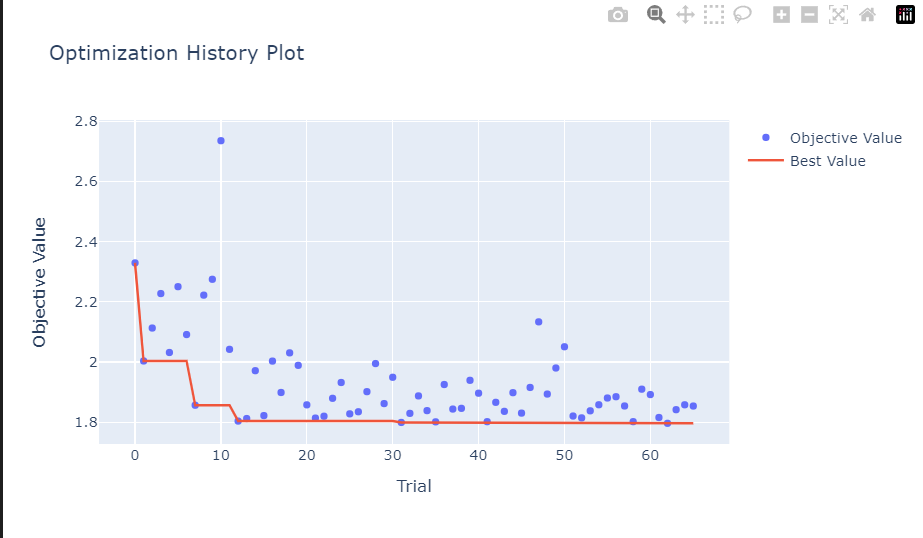



plot_param_importances(study)

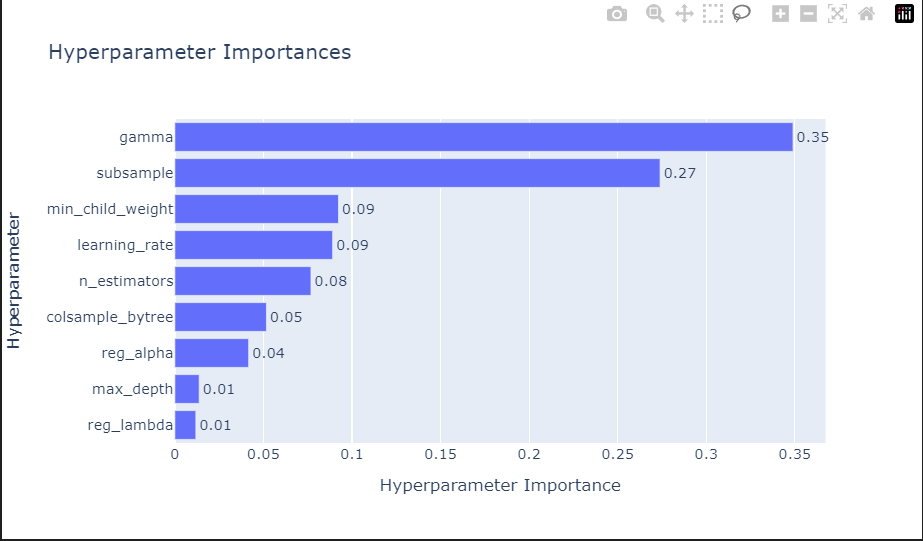

## Random Forest

In [14]:
# loss_fn = "squared_error" #'absolute_error', 'poisson', 'friedman_mse', 'squared_error'
# rf_model = RandomForest(loss_fn)
# rf_stock_predictor = StockPredictor(rf_model, window_size=window_size, stationary=stationary)
# rf_stock_predictor.fit_predict(X, y, df_stock)
# rf_stock_predictor.print_metrics()
# rf_stock_predictor.plot_residuals()
# rf_stock_predictor.show_feature_importance(n=100)
# hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
#     true_returns=rf_stock_predictor.true_returns,
#     predicted_returns=rf_stock_predictor.predicted_returns,
#     starting_funds=50000
# )

## LSTM

# Stationary

## Stationarity Check

In [104]:
significance_level = 0.05  
data = stock_data['AAPL']
results = []

for feature in data.columns:
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
print(nonstationary_features_list)
feature_stationarity.sort_values('p-value', ascending=False)

['Open', 'ATR', 'SMA', 'Lower Band', 'Upper Band', 'Volume_MA5', 'BB_Upper', 'BB_Lower', 'VPT', 'MA100', 'MA200', 'MA20', 'MA10', 'MA5', 'AD', 'Volume', 'Adj Close', 'Close', 'Low', 'High', 'MA50']


,Feature,Stationarity,p-value
10,MA50,nonstationary,9.859434e-01
30,BB_Upper,nonstationary,9.852933e-01
19,Upper Band,nonstationary,9.696534e-01
8,MA10,nonstationary,9.598414e-01
7,MA5,nonstationary,9.581930e-01
9,MA20,nonstationary,9.568627e-01
21,SMA,nonstationary,9.568627e-01
20,Lower Band,nonstationary,9.550818e-01
1,High,nonstationary,9.442359e-01
2,Low,nonstationary,9.424528e-01


In [105]:
stock_data_stationary = stock_data.copy()
for stock in stock_data: 
    data = stock_data[stock]
    if stock != "^IRX":
        # convert price related features into something stationary
        for feature in helper.PRICE_FEATURES_TO_CONVERT:
            data[feature] = (data[feature] - data['Close']) / data['Close']
        for feature in helper.ORIGINAL_PRICE_FEATURES:
            data[f'{feature}_diff'] = data[feature].pct_change() * 100

        data = data.dropna()
    stock_data_stationary[stock] = data

In [106]:
data = stock_data_stationary['AAPL']
results = []

for feature in data.columns.drop(helper.ORIGINAL_PRICE_FEATURES + helper.VOLUME_FEATURES_TO_CONVERT):
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
feature_stationarity.sort_values('p-value', ascending=False)


,Feature,Stationarity,p-value
17,ATR,nonstationary,4.661607e-01
27,VPT,nonstationary,2.560790e-01
30,Volume_MA5,nonstationary,1.135025e-01
29,AD,nonstationary,8.091282e-02
25,BB_Lower,stationary,4.691035e-03
6,MA200,stationary,3.811422e-03
24,BB_Upper,stationary,1.665398e-03
26,OBV,stationary,1.565963e-03
5,MA100,stationary,1.117267e-06
20,rangeHigh,stationary,3.854451e-07


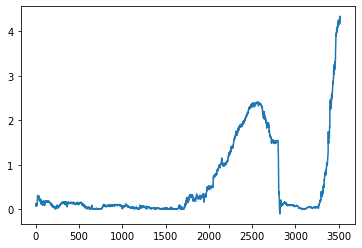

In [107]:
plt.plot(stock_data_stationary['^IRX']['Close'])

## Preprocessing

In [144]:
window_size = 40
stationary = True
X, y, df_stock = hp.prepare_data(stock_data_stationary, STOCK, fromDate, toDate, lag, stationary=stationary)

## XGBoost

In [145]:
loss_fn = 'reg:squarederror' #'reg:pseudohubererror'
xgboost_model_stationary = XGBoost(loss_fn)
xgboost_stock_predictor_stationary = StockPredictor(xgboost_model_stationary, window_size=window_size, stationary=stationary)
xgboost_stock_predictor_stationary.fit_predict(X, y, df_stock)
xgboost_stock_predictor_stationary.print_metrics()

Processing: 100%|██████████| 1802/1802 [02:36<00:00, 11.51it/s]

Mean Squared Error (MSE): 11.2201
Mean Absolute Error (MAE): 2.4674


2.4673813262251083

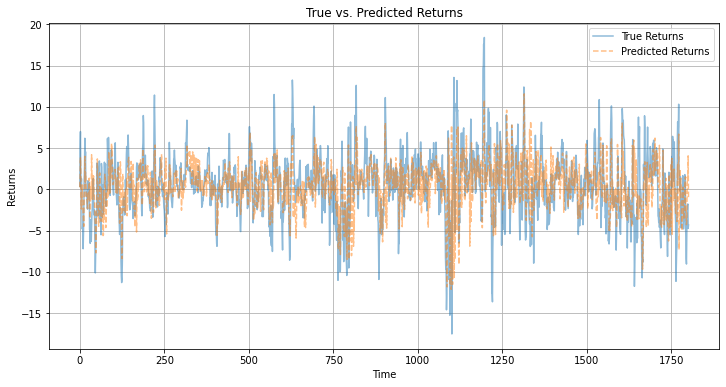

In [146]:
true_returns = xgboost_stock_predictor_stationary.true_returns
predicted_returns = xgboost_stock_predictor_stationary.predicted_returns
plt.figure(figsize=(12, 6))
plt.plot(true_returns, label='True Returns', linestyle='-', alpha=0.5)
plt.plot(predicted_returns, label='Predicted Returns', linestyle='--', alpha=0.5)
plt.title('True vs. Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


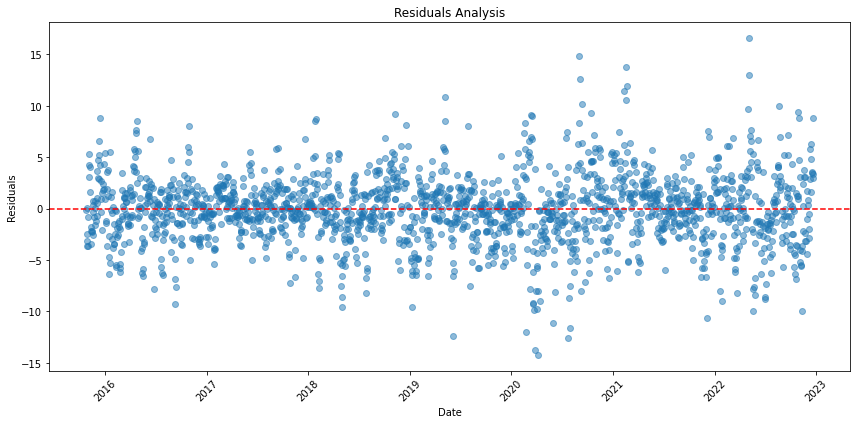

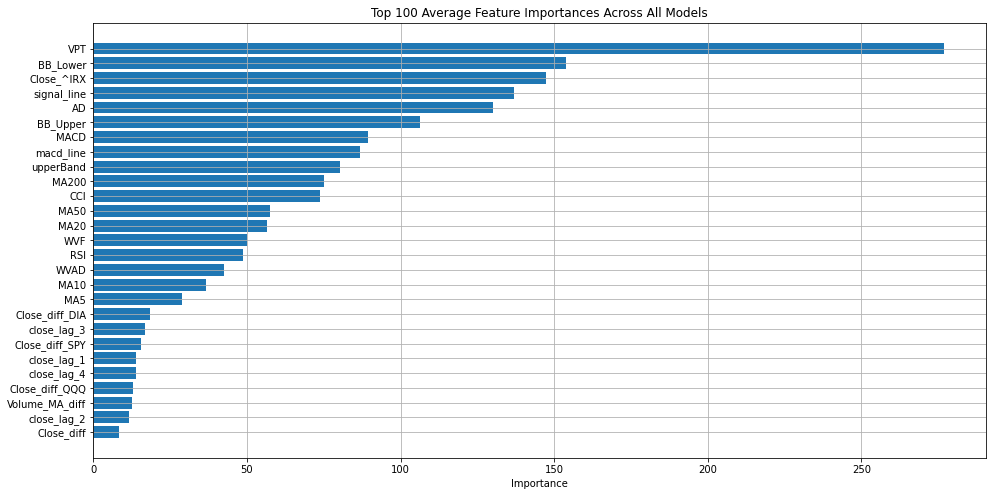

In [147]:
xgboost_stock_predictor_stationary.plot_residuals()
xgboost_stock_predictor_stationary.show_feature_importance(n=100)

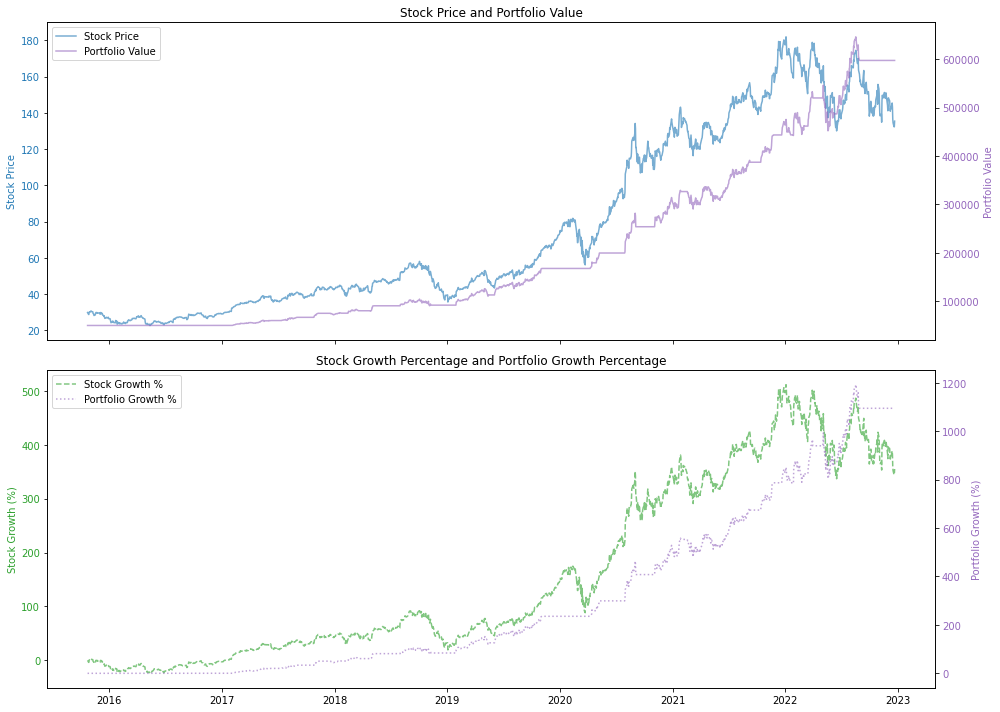

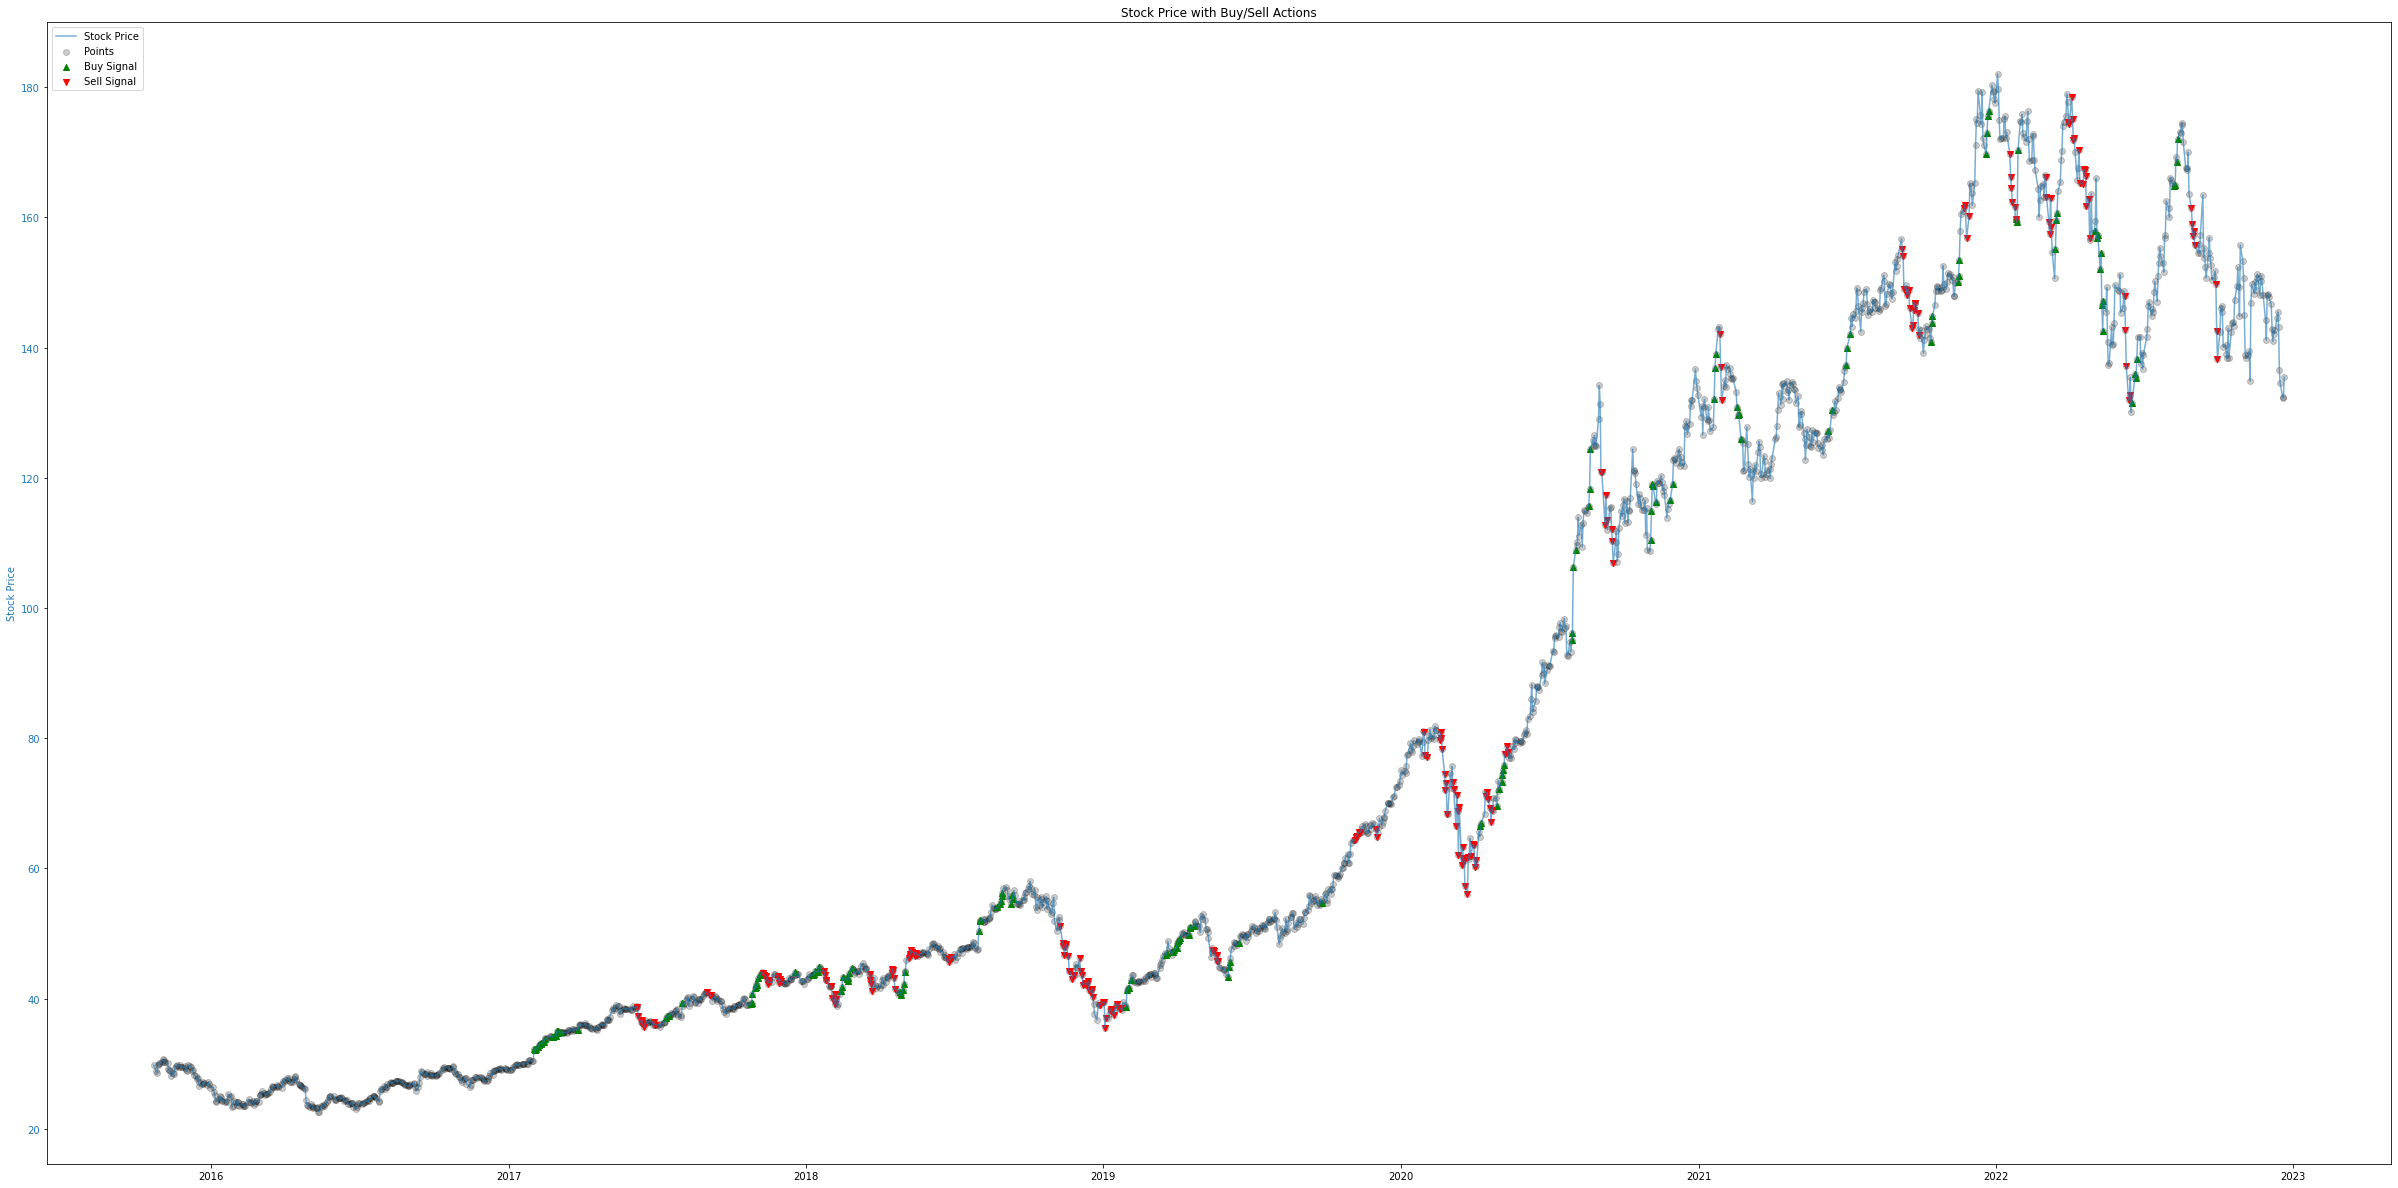

In [148]:
hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=xgboost_stock_predictor_stationary.true_returns,
    predicted_returns=xgboost_stock_predictor_stationary.predicted_returns,
    starting_funds=50000
)

## Random Forest

In [ ]:
# loss_fn = "squared_error" #'absolute_error', 'poisson', 'friedman_mse', 'squared_error'
# rf_model = RandomForest(loss_fn)
# rf_stock_predictor = StockPredictor(rf_model, window_size=window_size, stationary=stationary)
# rf_stock_predictor.fit_predict(X, y, df_stock)
# rf_stock_predictor.print_metrics()
# rf_stock_predictor.plot_residuals()
# rf_stock_predictor.show_feature_importance(n=100)
# hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
#     true_returns=xgboost_stock_predictor.true_returns,
#     predicted_returns=xgboost_stock_predictor.predicted_returns,
#     starting_funds=50000
# )

## LSTM